In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import random_split

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
from tqdm import tqdm

In [33]:
# Data agnostic
device = "cuda" if torch.cuda.is_available() else "cpu"

Make CNN for MNIST handwritten digit recognition

In [45]:
# Hyperparameters
batch_size = 64
learning_rate = 0.001
num_epochs = 10

In [47]:
# Load the MNIST dataset
trainDataset = datasets.MNIST(root='data/', train=True, transform=transforms.ToTensor(), download=True)
testDataset = datasets.MNIST(root='data/', train=False, transform=transforms.ToTensor())

# Create data loaders
trainLoader = torch.utils.data.DataLoader(dataset=trainDataset, batch_size=batch_size, shuffle=True)
testLoader = torch.utils.data.DataLoader(dataset=testDataset, batch_size=batch_size, shuffle=False)


torch.Size([28, 28])

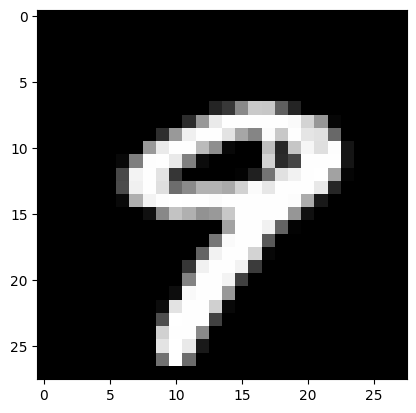

In [87]:
randInd = torch.randint(0,10,(1,))
image, label = testDataset[randInd.item()]
plt.imshow(image.squeeze(), cmap='gray')

image.squeeze().shape

CNN Model

In [35]:
class LeNet(nn.Module):
    def __init__(self, channels, classes):
        super(LeNet,self).__init__()
        
        # LeNet Architecture
        
        # First Block
        self.convBlock1 = nn.Conv2d(channels, 20, (5,5))
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d((2,2), (2,2))

        # Second Block
        self.convBlock2 = nn.Conv2d(20,50, (5,5))
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d((2,2), (2,2))

        # Fully Connected Layer
        self.fullyConnected1 = nn.Linear(800,500)
        self.relu3 = nn.ReLU()

        # Softmax for logit to predictions
        self.fullyConnected2 = nn.Linear(500,classes)
        self.logSoftmax = nn.LogSoftmax(dim=1)

    def forward(self,x):

        # First Block Pass
        x = self.maxpool1(self.relu1(self.convBlock1(x)))
        
        # Second Block Pass
        x = self.maxpool2(self.relu2(self.convBlock2(x)))
        
        # Flatten and pass to Fully Connected Layer
        x = self.relu3(self.fullyConnected1(torch.flatten(x,1)))

        # Softmax Pass
        x = self.fullyConnected2(x)
        output = self.logSoftmax(x)

        return output


Train Init

In [ ]:
# HYPERPARAMETERS
lr = 1e-3
lr = 1e-6
# lr = 0.01
BATCH_SIZE = 32
epochs = 100

# Split data
trainSplit = 0.8
valSplit = 1-trainSplit

trainSamples = int(len(trainDataset) * trainSplit)
valSamples = int(round(len(trainDataset) * valSplit,0))

(trainData, valData) = random_split(trainDataset, [trainSamples, valSamples], generator=torch.Generator().manual_seed(42))

In [ ]:
# Loaders
trainLoader = torch.utils.data.DataLoader(trainData, shuffle=True, batch_size=BATCH_SIZE)
valLoader = torch.utils.data.DataLoader(valData, batch_size=BATCH_SIZE)
testLoader = torch.utils.data.DataLoader(testDataset, batch_size=BATCH_SIZE)


# Batches
trainBatches = len(trainLoader.dataset) // BATCH_SIZE
valBatches = len(valLoader.dataset) // BATCH_SIZE

In [ ]:
# Init

model = LeNet(1,len(trainData.dataset.classes)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = lr)
lossFn = nn.NLLLoss()

modelRes = {
    "train_loss" : [],
    "train_acc" : [],
    "val_loss" : [],
    "val_acc" : []
}

# Timing
startTime = time.time()

Training and Testing Loop

In [64]:
# Training Loop

for epoch in tqdm(range(epochs), desc="Training Epochs"):
    
    model.train()

     # Create inner tqdm progress bar for batches
    train_batch_progress = tqdm(trainLoader, desc=f"Epoch {epoch+1}/{epochs}", unit="batch")

    totalTrainLoss = 0
    totalValLoss = 0

    trainCorrect = 0
    valCorrect = 0


    # Forward Pass
    for (x,y) in train_batch_progress:
        (x,y) = (x.to(device),y.to(device))

        # Loss
        pred = model(x)
        loss = lossFn(pred, y)
    
        # Optimizer Zero Grad
        optimizer.zero_grad()
    
        # Loss Backward
        loss.backward()

        # Optimizer Step 
        optimizer.step()

        totalTrainLoss += loss.item()
        totalTrainLoss = loss
        trainCorrect += (pred.argmax(1) == y).type(torch.float).sum().item() 
    
    model.eval()
    with torch.inference_mode():
        for (xVal, yVal) in valLoader:
            (xVal, yVal) = (xVal.to(device), yVal.to(device))

            # Forward Pass
            valPred = model(xVal)

            # Loss
            valLoss = lossFn(valPred, yVal)
            totalValLoss += valLoss.item()
            totalValLoss = valLoss

            valCorrect += (valPred.argmax(1) == yVal).type(torch.float).sum().item() 

    print(f'Train Loss: {totalTrainLoss} | Val Loss: {totalValLoss} | Val Correct: {valCorrect}')

        



Training Epochs:   1%|          | 1/100 [00:09<15:11,  9.21s/it]

Train Loss: 0.2529171109199524 | Val Loss: 0.3387524485588074 | Val Correct: 10571.0


Training Epochs:   2%|▏         | 2/100 [00:18<14:59,  9.18s/it]

Train Loss: 0.5280950665473938 | Val Loss: 0.20614312589168549 | Val Correct: 11471.0


Training Epochs:   3%|▎         | 3/100 [00:27<14:49,  9.17s/it]

Train Loss: 0.8333460688591003 | Val Loss: 0.16417691111564636 | Val Correct: 11211.0


Training Epochs:   4%|▍         | 4/100 [00:36<14:42,  9.19s/it]

Train Loss: 0.030068326741456985 | Val Loss: 0.06090026721358299 | Val Correct: 11629.0


Training Epochs:   5%|▌         | 5/100 [00:45<14:31,  9.17s/it]

Train Loss: 0.11224565654993057 | Val Loss: 0.2291586995124817 | Val Correct: 11392.0


Training Epochs:   6%|▌         | 6/100 [00:55<14:20,  9.15s/it]

Train Loss: 0.07230720669031143 | Val Loss: 0.15819086134433746 | Val Correct: 11530.0


Training Epochs:   7%|▋         | 7/100 [01:04<14:11,  9.15s/it]

Train Loss: 0.07913820445537567 | Val Loss: 0.1828167587518692 | Val Correct: 11257.0


Training Epochs:   8%|▊         | 8/100 [01:13<14:04,  9.18s/it]

Train Loss: 0.1196083053946495 | Val Loss: 0.13700784742832184 | Val Correct: 11126.0


Training Epochs:   9%|▉         | 9/100 [01:22<13:54,  9.17s/it]

Train Loss: 0.03485090285539627 | Val Loss: 1.8912642002105713 | Val Correct: 11376.0


Training Epochs:  10%|█         | 10/100 [01:31<13:45,  9.17s/it]

Train Loss: 0.03031325154006481 | Val Loss: 0.1278872936964035 | Val Correct: 11440.0


Training Epochs:  11%|█         | 11/100 [01:40<13:35,  9.16s/it]

Train Loss: 0.07062137871980667 | Val Loss: 0.7991161346435547 | Val Correct: 11498.0


Training Epochs:  12%|█▏        | 12/100 [01:49<13:25,  9.15s/it]

Train Loss: 0.3049714267253876 | Val Loss: 2.4100940227508545 | Val Correct: 11321.0


Training Epochs:  13%|█▎        | 13/100 [01:59<13:16,  9.15s/it]

Train Loss: 0.11491122841835022 | Val Loss: 0.2768561840057373 | Val Correct: 11062.0


Training Epochs:  14%|█▍        | 14/100 [02:08<13:06,  9.14s/it]

Train Loss: 0.18851664662361145 | Val Loss: 0.20048925280570984 | Val Correct: 11486.0


Training Epochs:  15%|█▌        | 15/100 [02:17<12:57,  9.15s/it]

Train Loss: 0.10950367897748947 | Val Loss: 0.19008128345012665 | Val Correct: 11290.0


Training Epochs:  16%|█▌        | 16/100 [02:26<12:49,  9.16s/it]

Train Loss: 0.10413263738155365 | Val Loss: 0.116792693734169 | Val Correct: 11369.0


Training Epochs:  17%|█▋        | 17/100 [02:35<12:40,  9.16s/it]

Train Loss: 0.14606709778308868 | Val Loss: 0.22238636016845703 | Val Correct: 11468.0


Training Epochs:  18%|█▊        | 18/100 [02:44<12:30,  9.15s/it]

Train Loss: 0.1268460601568222 | Val Loss: 0.3094710409641266 | Val Correct: 11306.0


Training Epochs:  19%|█▉        | 19/100 [02:54<12:20,  9.14s/it]

Train Loss: 0.1408599466085434 | Val Loss: 0.24537405371665955 | Val Correct: 11465.0


Training Epochs:  20%|██        | 20/100 [03:03<12:09,  9.12s/it]

Train Loss: 0.08032704889774323 | Val Loss: 0.12454605102539062 | Val Correct: 11463.0


Training Epochs:  21%|██        | 21/100 [03:12<12:00,  9.12s/it]

Train Loss: 0.1620122641324997 | Val Loss: 0.6134101152420044 | Val Correct: 11447.0


Training Epochs:  22%|██▏       | 22/100 [03:21<11:51,  9.12s/it]

Train Loss: 0.07960241287946701 | Val Loss: 0.13140372931957245 | Val Correct: 11582.0


Training Epochs:  23%|██▎       | 23/100 [03:30<11:43,  9.13s/it]

Train Loss: 0.05886903405189514 | Val Loss: 0.1415274739265442 | Val Correct: 11178.0


Training Epochs:  24%|██▍       | 24/100 [03:39<11:36,  9.16s/it]

Train Loss: 0.1543637067079544 | Val Loss: 0.11508173495531082 | Val Correct: 11391.0


Training Epochs:  25%|██▌       | 25/100 [03:48<11:26,  9.15s/it]

Train Loss: 0.48525476455688477 | Val Loss: 0.19594120979309082 | Val Correct: 11510.0


Training Epochs:  26%|██▌       | 26/100 [03:58<11:18,  9.17s/it]

Train Loss: 0.10142607986927032 | Val Loss: 0.20122817158699036 | Val Correct: 11334.0


Training Epochs:  27%|██▋       | 27/100 [04:07<11:15,  9.26s/it]

Train Loss: 0.18328233063220978 | Val Loss: 0.2009509801864624 | Val Correct: 11162.0


Training Epochs:  28%|██▊       | 28/100 [04:16<11:10,  9.31s/it]

Train Loss: 0.1291216015815735 | Val Loss: 0.1981608271598816 | Val Correct: 11332.0


Training Epochs:  29%|██▉       | 29/100 [04:26<11:05,  9.37s/it]

Train Loss: 0.06038818135857582 | Val Loss: 0.19987383484840393 | Val Correct: 11385.0


Training Epochs:  30%|███       | 30/100 [04:35<10:57,  9.39s/it]

Train Loss: 0.1295640766620636 | Val Loss: 0.19499263167381287 | Val Correct: 11366.0


Training Epochs:  31%|███       | 31/100 [04:45<10:47,  9.38s/it]

Train Loss: 0.2721027433872223 | Val Loss: 0.49447423219680786 | Val Correct: 10527.0


Training Epochs:  32%|███▏      | 32/100 [04:54<10:39,  9.40s/it]

Train Loss: 0.2195809781551361 | Val Loss: 0.21331745386123657 | Val Correct: 11364.0


Training Epochs:  33%|███▎      | 33/100 [05:04<10:30,  9.40s/it]

Train Loss: 0.06210826709866524 | Val Loss: 0.2618364095687866 | Val Correct: 11160.0


Training Epochs:  34%|███▍      | 34/100 [05:13<10:17,  9.36s/it]

Train Loss: 0.20882059633731842 | Val Loss: 0.2717492878437042 | Val Correct: 10906.0


Training Epochs:  35%|███▌      | 35/100 [05:22<10:04,  9.30s/it]

Train Loss: 3.8912596702575684 | Val Loss: 0.27812865376472473 | Val Correct: 11385.0


Training Epochs:  36%|███▌      | 36/100 [05:31<09:52,  9.26s/it]

Train Loss: 0.19533219933509827 | Val Loss: 0.2152966558933258 | Val Correct: 11207.0


Training Epochs:  37%|███▋      | 37/100 [05:41<09:46,  9.31s/it]

Train Loss: 0.13943889737129211 | Val Loss: 0.19379660487174988 | Val Correct: 11408.0


Training Epochs:  38%|███▊      | 38/100 [05:50<09:40,  9.36s/it]

Train Loss: 0.1314498782157898 | Val Loss: 0.11941708624362946 | Val Correct: 11382.0


Training Epochs:  39%|███▉      | 39/100 [06:00<09:31,  9.37s/it]

Train Loss: 0.09643476456403732 | Val Loss: 0.15613868832588196 | Val Correct: 11391.0


Training Epochs:  40%|████      | 40/100 [06:09<09:27,  9.45s/it]

Train Loss: 0.03252003341913223 | Val Loss: 0.18845677375793457 | Val Correct: 11299.0


Training Epochs:  41%|████      | 41/100 [06:19<09:16,  9.44s/it]

Train Loss: 0.07650067657232285 | Val Loss: 0.11485687643289566 | Val Correct: 11399.0


Training Epochs:  42%|████▏     | 42/100 [06:28<09:06,  9.42s/it]

Train Loss: 0.0 | Val Loss: 0.11271077394485474 | Val Correct: 11423.0


Training Epochs:  43%|████▎     | 43/100 [06:37<08:57,  9.43s/it]

Train Loss: 0.048347700387239456 | Val Loss: 0.15294024348258972 | Val Correct: 11331.0


Training Epochs:  44%|████▍     | 44/100 [06:47<08:50,  9.47s/it]

Train Loss: 0.0589110367000103 | Val Loss: 0.2382291555404663 | Val Correct: 11375.0


Training Epochs:  45%|████▌     | 45/100 [06:56<08:41,  9.48s/it]

Train Loss: 0.006646567489951849 | Val Loss: 0.20645618438720703 | Val Correct: 11359.0


Training Epochs:  46%|████▌     | 46/100 [07:06<08:32,  9.48s/it]

Train Loss: 0.09923184663057327 | Val Loss: 0.25867700576782227 | Val Correct: 10960.0


Training Epochs:  47%|████▋     | 47/100 [07:15<08:22,  9.49s/it]

Train Loss: 0.15814180672168732 | Val Loss: 0.2604697346687317 | Val Correct: 11225.0


Training Epochs:  48%|████▊     | 48/100 [07:25<08:19,  9.61s/it]

Train Loss: 0.03582525625824928 | Val Loss: 0.235571026802063 | Val Correct: 11036.0


Training Epochs:  49%|████▉     | 49/100 [07:35<08:08,  9.58s/it]

Train Loss: 0.6274030804634094 | Val Loss: 0.5465391874313354 | Val Correct: 10340.0


Training Epochs:  50%|█████     | 50/100 [07:44<07:53,  9.47s/it]

Train Loss: 0.32545846700668335 | Val Loss: 0.3184519410133362 | Val Correct: 10928.0


Training Epochs:  51%|█████     | 51/100 [07:54<07:47,  9.54s/it]

Train Loss: 0.15222783386707306 | Val Loss: 0.12407941371202469 | Val Correct: 11215.0


Training Epochs:  52%|█████▏    | 52/100 [08:04<07:48,  9.75s/it]

Train Loss: 0.19835825264453888 | Val Loss: 0.12989002466201782 | Val Correct: 11306.0


Training Epochs:  53%|█████▎    | 53/100 [08:14<07:35,  9.70s/it]

Train Loss: 0.36778104305267334 | Val Loss: 0.1280573010444641 | Val Correct: 11413.0


Training Epochs:  54%|█████▍    | 54/100 [08:23<07:20,  9.58s/it]

Train Loss: 0.12798672914505005 | Val Loss: 0.21129636466503143 | Val Correct: 10998.0


Training Epochs:  55%|█████▌    | 55/100 [08:32<07:07,  9.50s/it]

Train Loss: 0.04382358491420746 | Val Loss: 0.3118146061897278 | Val Correct: 11108.0


Training Epochs:  56%|█████▌    | 56/100 [08:41<06:55,  9.43s/it]

Train Loss: 0.09976132214069366 | Val Loss: 0.20233795046806335 | Val Correct: 11138.0


Training Epochs:  57%|█████▋    | 57/100 [08:51<06:43,  9.39s/it]

Train Loss: 0.09464462101459503 | Val Loss: 0.19417017698287964 | Val Correct: 11432.0


Training Epochs:  58%|█████▊    | 58/100 [09:00<06:36,  9.44s/it]

Train Loss: 0.2641077935695648 | Val Loss: 0.31980520486831665 | Val Correct: 11020.0


Training Epochs:  59%|█████▉    | 59/100 [09:09<06:23,  9.35s/it]

Train Loss: 0.26402735710144043 | Val Loss: 0.3817942142486572 | Val Correct: 10760.0


Training Epochs:  60%|██████    | 60/100 [09:19<06:11,  9.28s/it]

Train Loss: 0.22682321071624756 | Val Loss: 0.29814761877059937 | Val Correct: 11016.0


Training Epochs:  61%|██████    | 61/100 [09:28<06:00,  9.24s/it]

Train Loss: 0.2824069857597351 | Val Loss: 0.11246617138385773 | Val Correct: 11053.0


Training Epochs:  62%|██████▏   | 62/100 [09:37<05:50,  9.22s/it]

Train Loss: 0.12243583798408508 | Val Loss: 0.12498055398464203 | Val Correct: 11364.0


Training Epochs:  63%|██████▎   | 63/100 [09:47<05:48,  9.43s/it]

Train Loss: 0.1402970552444458 | Val Loss: 0.3069201111793518 | Val Correct: 11090.0


Training Epochs:  64%|██████▍   | 64/100 [09:56<05:36,  9.36s/it]

Train Loss: 0.2638929784297943 | Val Loss: 0.1257731020450592 | Val Correct: 11043.0


Training Epochs:  65%|██████▌   | 65/100 [10:06<05:30,  9.43s/it]

Train Loss: 0.20377610623836517 | Val Loss: 0.21336525678634644 | Val Correct: 11205.0


Training Epochs:  66%|██████▌   | 66/100 [10:15<05:22,  9.49s/it]

Train Loss: 0.3672432005405426 | Val Loss: 0.14220494031906128 | Val Correct: 11305.0


Training Epochs:  67%|██████▋   | 67/100 [10:25<05:13,  9.49s/it]

Train Loss: 0.18763107061386108 | Val Loss: 0.23597951233386993 | Val Correct: 10939.0


Training Epochs:  68%|██████▊   | 68/100 [10:34<05:00,  9.39s/it]

Train Loss: 0.21878638863563538 | Val Loss: 0.3029080331325531 | Val Correct: 11083.0


Training Epochs:  69%|██████▉   | 69/100 [10:43<04:52,  9.44s/it]

Train Loss: 0.258541077375412 | Val Loss: 0.34670567512512207 | Val Correct: 10788.0


Training Epochs:  70%|███████   | 70/100 [10:54<04:50,  9.69s/it]

Train Loss: 0.19696322083473206 | Val Loss: 0.34856879711151123 | Val Correct: 10837.0


Training Epochs:  71%|███████   | 71/100 [11:03<04:36,  9.53s/it]

Train Loss: 0.12828953564167023 | Val Loss: 0.19524261355400085 | Val Correct: 11221.0


Training Epochs:  72%|███████▏  | 72/100 [11:12<04:26,  9.54s/it]

Train Loss: 0.11584632843732834 | Val Loss: 0.059647150337696075 | Val Correct: 11173.0


Training Epochs:  73%|███████▎  | 73/100 [11:22<04:16,  9.51s/it]

Train Loss: 0.291568785905838 | Val Loss: 0.1859436333179474 | Val Correct: 11104.0


Training Epochs:  74%|███████▍  | 74/100 [11:31<04:04,  9.39s/it]

Train Loss: 0.46638017892837524 | Val Loss: 0.4882700443267822 | Val Correct: 10313.0


Training Epochs:  75%|███████▌  | 75/100 [11:40<03:52,  9.32s/it]

Train Loss: 0.2807011008262634 | Val Loss: 0.4157498776912689 | Val Correct: 10746.0


Training Epochs:  76%|███████▌  | 76/100 [11:49<03:43,  9.30s/it]

Train Loss: 0.33433157205581665 | Val Loss: 0.48734229803085327 | Val Correct: 10145.0


Training Epochs:  77%|███████▋  | 77/100 [11:59<03:34,  9.34s/it]

Train Loss: 0.33864957094192505 | Val Loss: 0.3713238835334778 | Val Correct: 10460.0


Training Epochs:  78%|███████▊  | 78/100 [12:08<03:25,  9.32s/it]

Train Loss: 0.1526155173778534 | Val Loss: 0.13720721006393433 | Val Correct: 10878.0


Training Epochs:  79%|███████▉  | 79/100 [12:17<03:15,  9.30s/it]

Train Loss: 0.24426144361495972 | Val Loss: 0.062284089624881744 | Val Correct: 11151.0


Training Epochs:  80%|████████  | 80/100 [12:26<03:03,  9.20s/it]

Train Loss: 0.18446190655231476 | Val Loss: 0.4230034351348877 | Val Correct: 10468.0


Training Epochs:  81%|████████  | 81/100 [12:36<02:54,  9.20s/it]

Train Loss: 0.06499162316322327 | Val Loss: 0.1477273404598236 | Val Correct: 11181.0


Training Epochs:  82%|████████▏ | 82/100 [12:45<02:46,  9.22s/it]

Train Loss: 0.108253613114357 | Val Loss: 0.20571522414684296 | Val Correct: 11141.0


Training Epochs:  83%|████████▎ | 83/100 [12:54<02:38,  9.29s/it]

Train Loss: 0.2917086184024811 | Val Loss: 0.1299826204776764 | Val Correct: 11104.0


Training Epochs:  84%|████████▍ | 84/100 [13:04<02:30,  9.41s/it]

Train Loss: 0.22054487466812134 | Val Loss: 0.2838183045387268 | Val Correct: 11238.0


Training Epochs:  85%|████████▌ | 85/100 [13:14<02:22,  9.48s/it]

Train Loss: 0.26316577196121216 | Val Loss: 0.38868001103401184 | Val Correct: 10911.0


Training Epochs:  86%|████████▌ | 86/100 [13:23<02:12,  9.45s/it]

Train Loss: 0.12712639570236206 | Val Loss: 0.22756001353263855 | Val Correct: 11190.0


Training Epochs:  87%|████████▋ | 87/100 [13:33<02:04,  9.59s/it]

Train Loss: 0.138389453291893 | Val Loss: 0.12754058837890625 | Val Correct: 11251.0


Training Epochs:  88%|████████▊ | 88/100 [13:44<01:58,  9.90s/it]

Train Loss: 0.12380362302064896 | Val Loss: 0.27395540475845337 | Val Correct: 11047.0


Training Epochs:  89%|████████▉ | 89/100 [13:53<01:46,  9.69s/it]

Train Loss: 0.3425276279449463 | Val Loss: 0.3670960068702698 | Val Correct: 10726.0


Training Epochs:  90%|█████████ | 90/100 [14:02<01:36,  9.66s/it]

Train Loss: 0.3433966636657715 | Val Loss: 0.5185450911521912 | Val Correct: 10411.0


Training Epochs:  91%|█████████ | 91/100 [14:12<01:25,  9.55s/it]

Train Loss: 0.42070162296295166 | Val Loss: 0.5189907550811768 | Val Correct: 10237.0


Training Epochs:  92%|█████████▏| 92/100 [14:21<01:15,  9.46s/it]

Train Loss: 0.3275339603424072 | Val Loss: 0.37915605306625366 | Val Correct: 10876.0


Training Epochs:  93%|█████████▎| 93/100 [14:30<01:06,  9.45s/it]

Train Loss: 0.2738719582557678 | Val Loss: 0.37140679359436035 | Val Correct: 10796.0


Training Epochs:  94%|█████████▍| 94/100 [14:40<00:57,  9.55s/it]

Train Loss: 0.31545281410217285 | Val Loss: 0.28046026825904846 | Val Correct: 11138.0


Training Epochs:  95%|█████████▌| 95/100 [14:50<00:47,  9.52s/it]

Train Loss: 0.3385157585144043 | Val Loss: 0.2549605965614319 | Val Correct: 10726.0


Training Epochs:  96%|█████████▌| 96/100 [14:59<00:38,  9.58s/it]

Train Loss: 0.3138388693332672 | Val Loss: 0.27362674474716187 | Val Correct: 10673.0


Training Epochs:  97%|█████████▋| 97/100 [15:09<00:28,  9.49s/it]

Train Loss: 0.31385183334350586 | Val Loss: 0.478374183177948 | Val Correct: 10241.0


Training Epochs:  98%|█████████▊| 98/100 [15:18<00:18,  9.43s/it]

Train Loss: 0.2184602916240692 | Val Loss: 0.3767787218093872 | Val Correct: 10919.0


Training Epochs:  99%|█████████▉| 99/100 [15:27<00:09,  9.38s/it]

Train Loss: 0.38901787996292114 | Val Loss: 0.14571639895439148 | Val Correct: 10838.0


Training Epochs: 100%|██████████| 100/100 [15:37<00:00,  9.37s/it]

Train Loss: 0.3876250386238098 | Val Loss: 0.21892422437667847 | Val Correct: 11234.0


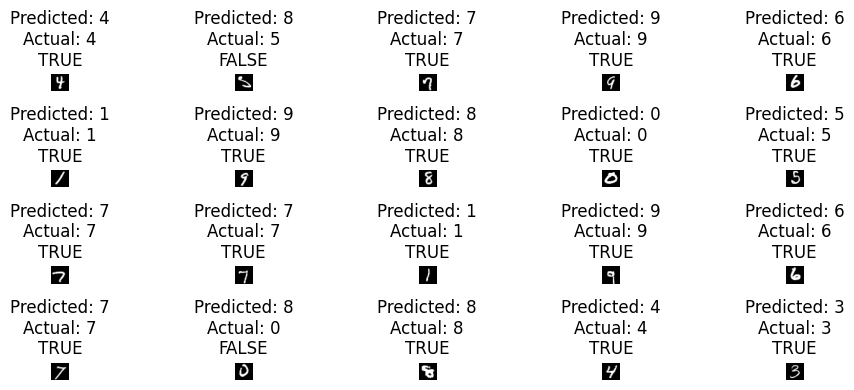

In [82]:
n = 20
cols = 5
fig, axs = plt.subplots(nrows=n//cols, ncols=cols, figsize=(10, 4))


for i in range(n):

    randInd = torch.randint(0,len(testDataset),(1,))
    image, label = testDataset[randInd.item()]

    axs[i // 5, i % 5].imshow(image.squeeze(), cmap="gray")
    axs[i // 5, i % 5].axis("off")

    model.eval()
    with torch.inference_mode():
        prediction = model(image.unsqueeze(0).to(device))


    predicted_class = torch.argmax(prediction).item()
    # print("Ground truth label:", label)
    # print(f"Predicted Digit: {predicted_class}")

    res = ""
    if label == predicted_class:
        res = "TRUE"
        # print("TRUE")
    else:
        res = "FALSE"
        # print("FALSE")
   
    axs[i // 5, i % 5].set_title(f"Predicted: {predicted_class}\nActual: {label}\n{res}")

plt.tight_layout()
plt.show()

Save Model

In [114]:
# Save Model
import os

baseName = "HDR.pth"
i = 1
fileName = baseName

while os.path.exists(fileName):
    fileName = f"{os.path.splitext(baseName)[0]}_{i}.pth"
    i += 1

torch.save(model.state_dict(), fileName)

torch.Size([1, 28, 28])


(-0.5, 27.5, 27.5, -0.5)

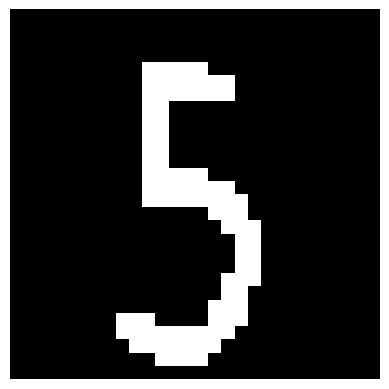

In [94]:
import base64
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
import torchvision.transforms
from torchvision.transforms import Resize, ToTensor, Grayscale

x = ""
# x = x.split(",")[1]
# print(x)


x = base64.b64decode(x)
image_array = np.frombuffer(x, np.uint8)
image = plt.imread(BytesIO(image_array))

# plt.imshow(image)
# plt.axis("off")


x = "iVBORw0KGgoAAAANSUhEUgAAAswAAAFwCAYAAACsMS2JAAAAAXNSR0IArs4c6QAAIABJREFUeF7t3W+obeldH/DfoxUkjnVCIZnEoZmBjI5TX+SPivZNZqxiEvvHgH2RFHQutBARQfKibwxkBvSFlFpSqIamZa5vqtBSA5akIDgTKGirTQfSTCedwEyoiYkhZMIktmCapzyTve25J3ufs/Zz9l77+fM5cLhn7qy1nt/v81vc+501a6+VwhcBAgQIECBAgAABAnsFEhsCBAgQIECAAAECBPYLCMzODgIECBAgQIAAAQJXCAjMTg8CBAgQIECAAAECArNzgAABAgQIECBAgECdgCvMdW72IkCAAAECBAgQmERAYJ5k0NokQIAAAQIECBCoExCY69zsRYAAAQIECBAgMImAwDzJoLVJgAABAgQIECBQJyAw17nZiwABAgQIECBAYBIBgXmSQWuTAAECBAgQIECgTkBgrnOzFwECBAgQIECAwCQCAvMkg9YmAQIECBAgQIBAnYDAXOdmLwIECBAgQIAAgUkEBOZJBq1NAgQIECBAgACBOgGBuc7NXgQIECBAgAABApMICMyTDFqbBAgQIECAAAECdQICc52bvQgQIECAAAECBCYREJgnGbQ2CRAgQIAAAQIE6gQE5jo3exEgQIAAAQIECEwiIDBPMmhtEiBAgAABAgQI1AkIzHVu9iJAgAABAgQIEJhEQGCeZNDaJECAAAECBAgQqBMQmOvc7EWAAAECBAgQIDCJgMA8yaC1SYAAAQIECBAgUCcgMNe52YsAAQIECBAgQGASAYF5kkFrkwABAgQIECBAoE5AYK5zsxcBAgQIECBAgMAkAgLzJIPWJgECBAgQIECAQJ2AwFznZi8CBAgQIECAAIFJBATmSQatTQIECBAgQIAAgToBgbnOzV4ECBAgQIAAAQKTCAjMkwxamwQIECBAgAABAnUCAnOdm70IECBAgAABAgQmERCYJxm0NgkQIECAAAECBOoEBOY6N3sRIECAAAECBAhMIiAwTzJobRIgQIAAAQIECNQJCMx1bvYiQIAAAQIECBCYREBgnmTQ2iRAgAABAgQIEKgTEJjr3OxFgAABAgQIECAwiYDAPMmgtUmAAAECBAgQIFAnIDDXudmLAAECBAgQIEBgEgGBeZJBa5MAAQIECBAgQKBOQGCuc7MXAQIECBAgQIDAJAIC8ySD1iYBAgQIECBAgECdgMBc52YvAgQIECBAgACBSQQE5kkGrU0CBAgQIECAAIE6AYG5zs1eBAgQIECAAAECkwgIzJMMWpsECBAgQIAAAQJ1AgJznZu9CBAgQIAAAQIEJhEQmCcZtDYJECBAgAABAgTqBATmOjd7ESBAgAABAgQITCIgME8yaG0SIECAAAECBAjUCQjMdW72IkCAAAECBAgQmERAYJ5k0NokQIAAAQIECBCoExCY69zsRYAAAQIECBAgMImAwDzJoLVJgAABAgQIECBQJyAw17nZiwABAgQIECBAYBIBgXmSQWuTAAECBAgQIECgTkBgrnOzFwECBAgQIECAwCQCAvMkg9YmAQIECBAgQIBAnYDAXOdmLwIECBAgQIAAgUkEBOZJBq1NAgQIECBAgACBOgGBuc7NXgQIECBAgAABApMICMyTDFqbBAgQIECAAAECdQICc52bvQgQIECAAAECBCYREJgnGbQ2CRAgQIAAAQIE6gQE5jo3exEgEBE5549HxPefEOPrEfHViPivEfHCZp2Pbn59+Z9TSk+dcH2HJkCAAAECITA7CQgQqBJYISxX1bVgp5ci4osXQ/eFML4N5Z++cJzt721//UxK6S8WrGMTAgQIEBhEQGAeZJDaILC2QM65XP2d9c+QHBFfjohPRsTn93x/rvx+Sqls54sAAQIEOhaY9S+7jkemdAJtCOScS2j0tUzgzyPiSxHx3KUr2+Ufy5Xr7RXtO65mp5S2/7xsFVsRIECAwEkEBOaTsDoogfEFBObmZry91aSE7ItBe2cgF8abm5+CCBBoWEBgbng4SiPQsoDA3PJ0Ftf2tYj4SkQ8felDlVUfqMw5vyKlVK6m+yJAgMBQAgLzUOPUDIH1BPYF5pTS0f5cyTnft+mo/Lr9+S0Xfu/NEfGd63VtpQUC5VadL0TEhyPimc338yml8rMvAgQIdClwtL/Yuuxe0QQIVAusEZiri7tix0shvGy5DeLl59ddCOOX/90DEfHKiHjFKeqa4JglSJf7uH8/Iv7LNkynlJ6foHctEiDQuYDA3PkAlU/gXAK9BuZjeOWcvysiXh0R92x+LT9f/P7rmyB+9zHWm+QY5faQf5lS+vlJ+tUmAQIdCQjMHQ1LqQRaEpg5MB8yh5zz6yOihMGLV6y3V7X3XdEu//6vTXq7ya8LzYecYbYlQGANAYF5DWVrEBhQQGBuZ6gXbjPZhvKLgfziLSfl52+PiAcjotWr3y+llP5qO7oqIUCAwLwvHTB7AgRuKCAw3xCwgd13fKiyXPHefsDyXB+oFJgbODeUQIDAnQKuMDsjCBCoEhCYq9iG3ynnfH9EPLT5/qGI+NHNhyWX/n3jlozhzxINEuhPYOkfYP11pmICBE4qIDCflHe4g+ecS4i+GKbfHhGvutCoD/0NN3UNERhHQGAeZ5Y6IbCqgMC8Kvewi3nZybCj1RiBoQQE5qHGqRkC6wkIzOtZW4kAAQIEzisgMJ/X3+oEuhUQmLsdncIJECBA4EABgflAMJsTIPANAYHZmUCAAAECswgIzLNMWp8EjiwgMB8Z1OEIECBAoFkBgbnZ0SiMQNsCAnPb81EdAQIECBxPQGA+nqUjEZhKQGCeatyaJUCAwNQCAvPU49c8gXoBgbnezp4ECBAg0JeAwNzXvFRLoBkBgbmZUSiEAAECBE4sIDCfGNjhCYwqIDCPOll9ESBAgMBlAYHZOUGAQJWAwFzFZicCBAgQ6FBAYO5waEom0IKAwNzCFNRAgAABAmsICMxrKFuDwIACAvOAQ9USAQIECOwUEJidGAQIVAkIzFVsdiJAgACBDgUE5g6HpmQCLQgIzC1MQQ0ECBAgsIaAwLyGsjUIDCggMA84VC0RIECAwE4BgdmJQYBAlYDAXMVmJwIECBDoUEBg7nBoSibQgoDA3MIU1ECAAAECawgIzGsoW4PAgAIC84BD1RIBAgQI7BQQmJ0YBAhUCQjMVWx2IkCAAIEOBQTmDoemZAItCAjMLUxBDQQIECCwhoDAvIayNQgMKCAwDzhULREgQIDATgGB2YlBgECVgMBcxWYnAgQIEOhQQGDucGhKJtCCgMDcwhTUQIAAAQJrCAjMayhbg8CAAgLzgEPVEgECBAjsFBCYnRgECFQJCMxVbHYiQIAAgQ4FBOYOh6ZkAi0ICMwtTEENBAgQILCGgMC8hrI1CAwoIDAPOFQtESBAgMBOAYHZiUGAQJWAwFzFZicCBAgQ6FBAYO5waEom0IKAwNzCFNRAgAABAmsICMxrKFuDwIACAvOAQ9USAQIECOwUEJidGAQIVAkIzFVsdiJAgACBDgUE5g6HpmQCLQgIzC1MQQ0ECBAgsIaAwLyGsjUIDCggMA84VC0RIECAwE4BgdmJQYBAlYDAXMVmJwIECBDoUEBg7nBoSibQgoDA3MIU1ECAAAECawgIzGsoW4PAgAIC84BD1RIBAgQI7BQQmJ0YBAhUCQjMVWx2IkCAAIEOBQTmDoemZAItCAjMLUxBDQQIECCwhoDAvIayNQgMKCAwDzhULREgQIDATgGB2YlBgECVgMBcxWYnAgQIEOhQQGDucGhKJtCCgMDcwhTUQIAAAQJrCAjMayhbg8CAAgLzgEPVEgECBAjsFBCYnRgECFQJCMxVbHYiQIAAgQ4FBOYOh6ZkAi0ICMwtTEENBAgQILCGgMC8hrI1CAwoIDAPOFQtESBAgMBOAYHZiUGAQJWAwFzFZicCBAgQ6FBAYO5waEom0IKAwNzCFNRAgAABAmsICMxrKFuDwIACAvOAQ9USAQIECOwUEJidGAQIVAkIzFVsdiJAgACBDgUE5g6HpmQCLQgIzC1MQQ0ECBAgsIaAwLyGsjUIDCggMA84VC0RIECAwE4BgdmJQYBAlYDAXMVmJwIECBDoUEBg7nBoSibQgoDA3MIU1ECAAAECawgIzGsoW4PAgAIC84BD1RIBAgQI7BQQmJ0YBAhUCQjMVWx2IkCAAIEOBQTmDoemZAItCAjMLUxBDQQIECCwhoDAvIayNQgMKCAwDzhULREgQIDATgGB2YlBgECVgMBcxWYnAgQIEOhQQGDucGhKJtCCgMDcwhTUQIAAAQJrCAjMayhbg8CAAgLzgEPVEgECBAjsFBCYnRgECFQJCMxVbHYiQIAAgQ4FBOYOh6ZkAi0ICMwtTEENBAgQILCGgMC8hrI1CAwoIDAPOFQtESBAgMBOAYHZiUGAQJWAwFzFZicCBAgQ6FBAYO5waEom0IKAwNzCFNRAgAABAmsICMxrKFuDwIACAvOAQ9USAQIECOwUEJidGAQIVAkIzFVsdiJAgACBDgUE5g6HpmQCLQgIzC1MQQ0ECBAgsIaAwLyGsjUIDCggMA84VC0RIECAwE4BgdmJQYBAlYDAXMVmJwIECBDoUEBg7nBoSibQgoDA3MIU1ECAAAECawgIzGsoW4PAgAIC84BD1RIBAgQI7BQQmJ0YBAhUCQjMVWx2IkCAAIEOBQTmDoemZALnFsg5PxoRT+yqI6Xkz5VzD8j6BAgQIHBUAX+xHZXTwQjMIXBFYH42pfR9cyjokgABAgRmERCYZ5m0PgkcUSDn/D8i4sEdh7yVUrp9xKUcigABAgQInF1AYD77CBRAoD+BnPP/jYhv2VH5/SmlF/rrSMUECBAgQGC/gMDs7CBA4GABH/g7mMwOBAgQINCxgMDc8fCUTuBcAgLzueStS4AAAQLnEBCYz6FuTQKdCwjMnQ9Q+QQIECBwkIDAfBCXjQkQKAICs/OAAAECBGYSEJhnmrZeCRxJQGA+EqTDECBAgEAXAgJzF2NSJIG2BATmtuahGgIECBA4rYDAfFpfRycwpIDAPORYNUWAAAECewQEZqcGAQIHCwjMB5PZgQABAgQ6FhCYOx6e0gmcQ+CK12JHSsmfKecYijUJECBA4KQC/nI7Ka+DExhP4IrXYj+bUvq+8TrWEQECBAjMLiAwz34G6J/AgQJXvBb7Vkrp9oGHszkBAgQIEGheQGBufkQKJNCWgPuX25qHaggQIEDg9AIC8+mNrUBgKAGBeahxaoYAAQIEFggIzAuQbEKAwP8XEJidDQQIECAwm4DAPNvE9UvghgIzBuac87ellP7ihnR2J0CAAIFOBQTmTgenbALnEhglMOecvysiXh0R92x+LT9f/n4oIr5zBeuXIuKLEfHC5rssWX7+9Gbt8vPLv5dS2v68QlmWIECAAIEiIDA7DwgQWCzQ6jOYc84l2P55RNwXEW/ZNFR+Lt9vXin0LnY8woZfi4g/iYinIuKj5VdB+giqDkGAAIE9AgKzU4MAgcUCLTyDeROO3xQR5fsdm1C8uIeBNyxXnrcBulyJLj/7IkCAAIEjCAjMR0B0CAKzCKz1DOac88MXgnC5YnxXRLwtIr5jFusj9SlEHwnSYQgQmFtAYJ57/roncJDAMe5fzjm/IiJ+6FIgLnX8VETcfVBBNj5UYHsrx+Nu4ziUzvYECMwsIDDPPH29EzhQ4JDAnHO+PyLKvcXb7x+PiNdExLccuKzNTydQbtso389ExNMppedOt5QjEyBAoF8Bgbnf2amcwOoC+wLz6oUcb8HydIoSFj+/5/tz5fdTSl8+3pJ3HinnXD6YWL4u//q6S7/37RHx4Imvwn8sIn45pfQ7p+rXcQkQINCjgMDc49TUTOBMAo0H5q9GxMcj4tkLj2YrT5CIyx+A6/25ypuQXe7zLvd3l6Bdfj7m15MR8cGU0m8d86CORYAAgV4FBOZeJ6duAmcQaCgwlw+zlaug5Yrox1JK5SrxtF+bAL19jF4J0Rc/NHkTl+L8rzbh+c9uciD7EiBAoGcBgbnn6amdwMoCKwbmFyPiQ5v2Xr5KvLnX9hWzh+OlI790Ffqtmxe0LN1913afjIj3p5R+4yYHsS8BAgR6FBCYe5yamgmcSSDnXG55+P4jLF9un/hIRHxl8+KNbSAut094k90RgHcdYvO4vnIF+tEbPL96+6i63/Ss5xMNymEJEGhOQGBubiQKItC2wAGhOUfEFyLiw5sP1pXbJp5JKT3fdodzVLcJzz8RET8TEa+t7LqE59vlP3qE50pBuxEg0IWAwNzFmBRJoC+B8qzllFJ5VbWvDgRyzq+KiH8UEf/whleeS3guV579X4IO5q5EAgSWCwjMy61sSYAAgeEFcs7v3ITnRyqbLWG5fJfgXAK0LwIECHQvIDB3P0INECBA4PgCOed3RMR7I+JNNzi6NwveAM+uBAi0IyAwtzMLlRAgQKA5gZzzAxHxtyPi7x7hec/bNwuWJ5+84NaN5satIAIE9ggIzE4NAgQIEFgkcOFRdT97hPBc1nw6In41pfTbiwqwEQECBM4kIDCfCd6yBAgQ6FlgE563wfmmbxrcfliwXIH2RYAAgeYEBObmRqIgAgQI9CVwITw/dsPKy4cFH/dhwRsq2p0AgaMLCMxHJ3VAAgQIzClw4ZaNX9o8nu6vVEq8/HznlNLjlfvbjQABAkcVEJiPyulgBAgQILAVOMKbBQVnpxMBAk0ICMxNjEERBAgQGFtgE57/XkT8VMXLUUpw/lBEfDClVN4Y6YsAAQKrCgjMq3JbjAABAgRueM/zH0fEu1JKz5EkQIDAWgIC81rS1iFAgACBOwQuBOdHK646fyAifk1wdlIRILCGgMC8hrI1CBAgQGCvwA2f7yw4O7cIEDi5gMB8cmILECBAgMBSgZxzudpc82KUP4qIR93jvFTadgQIHCIgMB+iZVsCBAgQWEVgc9X5fSUEH7DglyLiTV65fYCYTQkQWCQgMC9ishEBAgQInEMg5/xQeSZzRPzgAevf8vKTA7RsSoDAtQIC87VENiBAgACBcwvknB+IiPdExLsX1lJes12Cc3kknS8CBAjcSEBgvhGfnQkQIEBgTYEDg/OLEfFGoXnNCVmLwJgCAvOYc9UVAQIEhhbYBOffjYjvvabRcoX5EaF56NNBcwROLiAwn5zYAgQIECBwKoGc869ExM9ExL1XrFFC8+Puaz7VFByXwPgCAvP4M9YhAQIEhhbYvHb7dyLi7mtC8+2U0uNDY2iOAIGTCAjMJ2F1UAIECBBYU2DzGLoSmt9wzbqPCc1rTsZaBMYQEJjHmKMuCBAgQCAics7l2c2PXYPxdES8w33NThkCBJYKCMxLpWxHgAABAl0ILAzNn4uIHxGauxipIgmcXUBgPvsIFECAAAECxxbY3KLx/DXHLR8GLM9qLs9s9kWAAIG9AgKzk4MAAQIEhhTYhOYnI+K+axp0X/OQZ4CmCBxPQGA+nqUjESBAgEBjAgeEZm8GbGx2yiHQkoDA3NI01EKAAAECRxc44AkaT6eU3nj0AhyQAIHuBQTm7keoAQIECBBYIrD5MOCj19yiUd4K6J7mJaC2ITCRgMA80bC1SoAAgdkFNi85eeKK0PxiSumVszvpnwCBOwUEZmcEAQIECEwlsLlF4+MRcdeexj+VUnpgKhTNEiBwpYDA7AQhQIAAgekErgnNX0spfdt0KBomQGCvgMDs5CBAgACBKQU2t2eUx87t+npbSuk/TgmjaQIEvklAYHZSECBAgMC0Ajnn8nKTXc9p/mxK6bunhdE4AQJ3CAjMTggCBAgQmFYg5/wLEfHP9wB8T0rpuWlxNE6AwF8KCMxOBgIECBCYViDn/FBEfGIPwAdSSj83LY7GCRAQmJ0DBAgQIECgCOSc/ygifsBVZucDAQL7BFxhdm4QIECAwNQC13z475MppQenBtI8AQIhMDsJCBAgQGB6gZzzb0TEu/dA3JVS+ur0SAAITCwgME88fK0TIECAwDcEcs7lRSX/c4/HO1NKv82KAIF5BQTmeWevcwIECBC4IJBz/kxEvHYHymdSSvfCIkBgXgGBed7Z65wAAQIE7gzMb42Ij+xA+XpK6VthESAwr4DAPO/sdU6AAAECdwbm8gKT8iKTb/pKKfn70tlCYGIBfwBMPHytEyBAgMCdAjnnLDA7KwgQuCwgMDsnCBAgQIDARkBgdioQILDzP5qxECBAgAABAt8QEJidCQQICMzOAQIECBAgcIWAwOz0IEBAYHYOECBAgAABgdk5QIDAgQLuYT4QzOYECBAgMK6AK8zjzlZnBG4iIDDfRM++BAgQIDCUgMA81Dg1Q+BoAgLz0SgdiAABAgR6FxCYe5+g+gmcRkBgPo2roxIgQIBAhwICc4dDUzKBFQQE5hWQLUGAAAECfQgIzH3MSZUE1hYQmNcWtx4BAgQINCsgMDc7GoUROKuAwHxWfosTIECAQEsCAnNL01ALgXYEBOZ2ZqESAgQIEDizgMB85gFYnkCjAgJzo4NRFgECBAisLyAwr29uRQI9CAjMPUxJjQQIECCwioDAvAqzRQh0JyAwdzcyBRMgQIDAKQRyzg9HxJM7jv2ZlNK9p1jTMQkQ6ENAYO5jTqokQIAAgRML5JwfjYgndixzO6V068TLOzwBAg0LCMwND0dpBAgQILCeQM75fRHx2I4VH0spPb5eJVYiQKA1AYG5tYmohwABAgTOIpBzLleXy1Xmy1+3Ukq3z1KURQkQaEJAYG5iDIogQIAAgXML5Jxfioi7dtTxSErpqXPXZ30CBM4nIDCfz97KBAgQINCQwL4nZETE/SmlFxoqVSkECKwsIDCvDG45AgQIEGhTwCPl2pyLqgi0ICAwtzAFNRAgQIDAWQWueELGCyml+89anMUJEDi7gMB89hEogAABAgTOLeCRcueegPUJtC0gMLc9H9URIECAwAoCnpCxArIlCHQsIDB3PDylEyBAgMBxBHLOX4qIu3cczSPljkPsKAS6FhCYux6f4gkQIEDgGAKekHEMRccgMK6AwDzubHVGgAABAgsErrh/OVJK/p5cYGgTAqML+INg9AnrjwABAgSuFMg5Px8R9+3Y6FMppQfwESBAQGB2DhAgQIDAtAJXXV2OCG/4m/bM0DiBOwUEZmcEAQIECEwrkHN+MiIe3gHwVErpkWlhNE6AwB0CArMTggABAgSmFMg5/2RE/Ic9zXs6xpRnhaYJ7BYQmJ0ZBAgQIDClQM752Yj43l3N+7DflKeEpgnsFRCYnRwECBAgMJ1AzvlVEfH5PY2/J6X0z6ZD0TABAgKzc4AAAQIECGwFcs6/FBG/vEfke1JKz9EiQIDAVsAVZucCAQIECEwncMWj5D6WUnrzdCAaJkDgSgGB2QlCgAABAlMJ5JzfGRH/Zk/TP5JS+sOpQDRLgMC1AgLztUQ2IECAAIGRBHLOv1+esbyjpydTSj86Uq96IUDgOAIC83EcHYUAAQIEOhDIOf9wRPzBnlLflVL6rQ7aUCIBAisLCMwrg1uOAAECBM4nkHP+bES8ZkcFL6SU7j9fZVYmQKBlAYG55emojQABAgSOJpBz/rGI+L09B3xvSulXjraYAxEgMJSAwDzUODVDgAABAvsEcs7/KyLu3fPvX51S+jN6BAgQ2CUgMDsvCBAgQGB4gZzzkxHx8J5GP5lSenB4BA0SIFAtIDBX09mRAAECBHoQyDmXoFwC866v/xMR96SUvtxDL2okQOA8AgLzedytSoAAAQIrCeScX4qIu/Ys90hK6amVSrEMAQKdCgjMnQ5O2QQIECBwvUDOubzi+vV7trydUrp1/VFsQYDA7AIC8+xngP4JECAwqEDO+dGIeGJPex4jN+jctUXgFAIC8ylUHZMAAQIEziqQc74vIp6/ogi3Ypx1QhYn0JeAwNzXvFRLgAABAgsErnkqxtMppTcuOIxNCBAg8LKAwOxEIECAAIGhBHLO5TaMcjvGrq8XU0qvHKphzRAgcHIBgfnkxBYgQIAAgbUErrlvuZThVoy1hmEdAgMJCMwDDVMrBAgQmFlgwX3Lt1JKt2c20jsBAnUCAnOdm70IECBAoDGBnHP5kF/5sN+uL4+Qa2xeyiHQk4DA3NO01EqAAAECOwWuCcseIee8IUDgRgIC84347EyAAAEC5xbIOb8vIh67og73LZ97SNYn0LmAwNz5AJVPgACBmQVyzg9HxJNXGLhveeYTRO8EjiQgMB8J0mEIECBAYF2BBWHZ85bXHYnVCAwrIDAPO1qNESBAYFyBBU/E+FxK6TXjCuiMAIE1BQTmNbWtRYAAAQJHEcg5/2lE3LPnYD7kdxRlByFAYCsgMDsXCBAgQKArgZzzJyLioSuK9iG/riaqWALtCwjM7c9IhQQIECCwEcg5/9uI+Glh2SlBgMCaAgLzmtrWIkCAAIFqgQVh+f0ppV+sXsCOBAgQ2CMgMDs1CBAgQKB5gQVh2Yf8mp+iAgn0KyAw9zs7lRMgQGAKgZzzhyPibVc0+0xK6W9MgaFJAgTOIiAwn4XdogQIECCwROCaV16XQ/y7lNLfX3Is2xAgQKBWQGCulbMfAQIECJxUQFg+Ka+DEyBwgIDAfACWTQkQIEBgHYEFt2G4srzOKKxCgEBECMxOAwIECBBoSmDBB/w+klJ6e1NFK4YAgaEFBOahx6s5AgQI9CWwICx7i19fI1UtgSEEBOYhxqgJAgQI9C+w4DYMYbn/MeuAQJcCAnOXY1M0AQIExhJY8AE/t2GMNXLdEOhKQGDualyKJUCAwHgCC8KyD/iNN3YdEehKQGDualyKJUCAwFgCC27DEJbHGrluCHQpIDB3OTZFEyBAoH+BBR/wcxtG/2PWAYEhBATmIcaoCQIECPQlkHP+REQ8dEXVPuDX10hVS2BoAYF56PFqjgABAm0J5Jzvi4g/iIh7hOW2ZqMaAgT2CwjMzg4CBAgQWEUg5/xoRDxxzWJuw1hlGhYhQOAQAYH5EC3bEiBAgEB3G74jAAAIA0lEQVSVQM65BOUSmK/68gG/Kl07ESBwagGB+dTCjk+AAIGJBTa3YJSw/PA1DO5Znvg80TqB1gUE5tYnpD4CBAh0KrDwFozS3adSSg902qayCRCYQEBgnmDIWiRAgMDaAjnn/xYRb1iw7j9OKf2TBdvZhAABAmcTEJjPRm9hAgQIjCew8CkYpfEXIuJWSump8RR0RIDAaAIC82gT1Q8BAgTOJHDALRi3U0q3zlSmZQkQIHCwgMB8MJkdCBAgQOCywMKnYJTdylXl2wQJECDQk4DA3NO01DqlwOZ/cX8hpfTVKQE03bTAAU/B+EpE/B23YDQ9TsURILBHQGB2ahBoVCDn/B0R8aGI+LFNif86In41pfRcoyUrazKBA27BeDql9MbJeLRLgMBAAgLzQMPUylgCOedfj4if29HVZyPi30fEf46Ij6WUnhmrc930IJBzLv/h9voFtboFYwGSTQgQaFtAYG57PqqbVGBzdbn8L+wlX1+PiE9HxL9IKf3TJTvYhkCtQM65vIDkdyPirmuO4SkYtcj2I0CgOQGBubmRKIhAxOa+0OcrLEpIKY/p+qgPVlXo2eVKgZzzkwve2FeO4SkYziUCBIYSEJiHGqdmRhLIOf/ehfuXa1oTnmvU7PNNAjnnt0bEByPi3gU8bsFYgGQTAgT6EhCY+5qXaicS2NyWUd6Atus+5kMlvhYRf1Ku/G2uPntZxKGCE26fcy6vqy7nymsXtP9iRLzDUzAWSNmEAIHuBATm7kam4NkENveMlqt7Sz5gtZSnXH2+eAVagF4qN8F2m6D8noh498J2PQVjIZTNCBDoU0Bg7nNuqp5QYHPF+W9GxKs395H+rYi470gUAvSRIHs+TEVQ9sG+ngeudgIEFgsIzIupbEigPYHNhwN/IiJ+OCIePWKF5RaO/x4R7/fhwSOqNnqoiqBcOvHBvkbnqSwCBI4vIDAf39QRCZxFYBOeyyO/3nLk8Ly9deM33Z96ltGebNHKoPy/I+LtzoWTjcWBCRBoUEBgbnAoSiJwU4FNeP7piPgHEfGGmx7vwv4lPPvg4BFBz3GonPNDmzn+4IHrPxsRP+A17Qeq2ZwAge4FBObuR6gBAlcLbMJz2ahcff7Zhc/RXcK6Dc/lynP52VfjAptz4X0V/wfiAxHxa17L3viAlUeAwMkEBOaT0TowgTYFThCgtx8YLMG5XH321ZhAznkbkg/9kKig3NgslUOAwHkEBObzuFuVQDMCFwJ0uYXj52/45I3t855ffttgeXSde13PM+rNXMv/UXisogJBuQLNLgQIjCsgMI87W50RqBK48OHBY9++IURXTWT5ThdCcnliyqFXk8tCgvJyblsSIDCRgMA80bC1SuBQgROF520Z21s5yq+uRh86nM32RwjJ5Uh/HBHvco9y5RDsRoDA8AIC8/Aj1iCB4whcCGblw4Pl+xRfl2/peMoHCu9kPuIcyn+ofCgi3uupF6c4lR2TAIGRBATmkaapFwIrCdzw/thDq/zLV3jPek/0ka4iX7yyX1468vihg7A9AQIEZhUQmGedvL4JHEHghM97vq66oUL0pSeXvG7TfLmKX+5DrrkXeZdfMXvck0yuO7X8ewIECHyzgMDsrCBA4GgCl942uA17xwp8V9VZbuX4yuYWg7Ldy/dEb65In/0Z0VcE4lLrqW5vKccuLv8pIm65teVop7kDESAwoYDAPOHQtUxgTYFNWNyG5/La7vLzKUPi5fa2gbk8pePGYfpC+C3H2va1vSp88ffKz+Uti3ev6b35DwVvY1wZ3XIECIwtIDCPPV/dEWhS4NIV158sr1s+4q0HTfZ8wqK2TxspH5B0X/IJoR2aAIF5BQTmeWevcwLNCey4pWPNK9HNeVxR0Pa15B/1YpiexqZWAgR6FRCYe52cuglMILDjdo7tB+Em6P6OFreP2/N0i9kmr18CBJoQEJibGIMiCBBYKnDhKvRIt3Js77PePv2jcHx61sfoLT0XbEeAAIG1BATmtaStQ4DAyQR2XIkua6394cKr+ts+xePpiNh++FAgPtkZ4cAECBA4roDAfFxPRyNAoDGBPWH6xyPiu29Q6ksR8cXto+s2x9leJX45CG9/z+PcbqBsVwIECDQiIDA3MghlECBAgAABAgQItCkgMLc5F1URIECAAAECBAg0IiAwNzIIZRAgQIAAAQIECLQpIDC3ORdVESBAgAABAgQINCIgMDcyCGUQIECAAAECBAi0KSAwtzkXVREgQIAAAQIECDQiIDA3MghlECBAgAABAgQItCkgMLc5F1URIECAAAECBAg0IiAwNzIIZRAgQIAAAQIECLQpIDC3ORdVESBAgAABAgQINCIgMDcyCGUQIECAAAECBAi0KSAwtzkXVREgQIAAAQIECDQiIDA3MghlECBAgAABAgQItCkgMLc5F1URIECAAAECBAg0IiAwNzIIZRAgQIAAAQIECLQpIDC3ORdVESBAgAABAgQINCIgMDcyCGUQIECAAAECBAi0KSAwtzkXVREgQIAAAQIECDQiIDA3MghlECBAgAABAgQItCkgMLc5F1URIECAAAECBAg0IiAwNzIIZRAgQIAAAQIECLQpIDC3ORdVESBAgAABAgQINCIgMDcyCGUQIECAAAECBAi0KSAwtzkXVREgQIAAAQIECDQiIDA3MghlECBAgAABAgQItCkgMLc5F1URIECAAAECBAg0IiAwNzIIZRAgQIAAAQIECLQp8P8Ao+bDy2qdaFgAAAAASUVORK5CYII="

x = base64.b64decode(x)
image = Image.open(BytesIO(x))
desiredSize = (28,28)

# Transform
transform = transforms.Compose([
    Resize(desiredSize),
    transforms.Grayscale(),
    ToTensor(),
])
transformed_image = transform(image)


print(transformed_image.shape)

a = transformed_image.numpy()
a = a.transpose(1,2,0)
plt.imshow(a, cmap="gray")
plt.axis("off")

In [81]:
model = LeNet(1,10)
state_dict = torch.load("HDR.pth", torch.device(device))
model.load_state_dict(state_dict)
model = model.to(device)

In [93]:
# model(transformed_image.squeeze())
# torch.argmax(model(image.unsqueeze(0).to(device))).item()
torch.argmax(model(transformed_image.unsqueeze(0).to(device))).item()


5